# ML to find radial velocities using FIRE data

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys
import gzip
import matplotlib.gridspec as gridspec

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
data = np.load('StarsWithRadialVelocity.npy')

In [3]:
data_cols = ['l', 'b','ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity',
             'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
             'pmra_error', 'pmdec_error', 'parallax_error', 'radial_velocity_error',
             'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error',
             'AccretedLabel'
            ]
#could train on radial_velocity_error

In [4]:
data = pd.DataFrame(data, columns=data_cols)

In [5]:
data.shape

(11400846, 19)

In [6]:
data.head()


,l,b,ra,dec,pmra,pmdec,parallax,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra_error,pmdec_error,parallax_error,radial_velocity_error,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,AccretedLabel
0,18.947771,17.087326,261.281075,-4.105546,0.304014,-2.012651,0.443537,44.472788,14.384683,14.678857,13.931516,0.091557,0.091557,0.044116,9.908263,0.000611,0.003929,0.003929,0.0
1,-4.978819,-41.542610,315.656827,-45.372252,15.768343,-16.975898,1.369992,-120.045033,12.405884,12.633657,12.030871,0.087001,0.087001,0.042780,2.036502,0.000342,0.002105,0.002105,0.0
2,-137.539419,-47.311996,60.814237,-25.789371,5.542696,9.388474,0.597262,83.063864,14.347357,14.619976,13.923520,0.091365,0.091365,0.044055,9.917098,0.000602,0.003861,0.003861,0.0
3,-68.315598,-32.353069,71.998054,-78.933526,14.320530,-13.669455,0.862436,-106.062495,14.062039,14.311761,13.648176,0.090130,0.090130,0.043668,7.792049,0.000544,0.003407,0.003407,0.0
4,85.879721,-52.988838,351.547535,3.638489,2.937268,5.109022,1.510236,-23.143291,14.677980,15.082906,14.107460,0.093275,0.093275,0.044678,11.110764,0.000683,0.004529,0.004529,0.0


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

In [8]:
# What columns to use?
use_cols = ['l', 'b','parallax','pmra','pmdec']
# Make the design matrix
X = data[use_cols].values
Y = (data['radial_velocity']).values
#Y = (Y - np.mean(Y))/(np.std(Y))

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X[1:500000], Y[1:500000],
                                                    test_size = 0.2,
                                                    random_state=42)


In [10]:
print(Y[1:50])

[-120.0450329    83.06386364 -106.06249519  -23.14329118   76.44296107
  -46.41827695  -14.63364152  145.08926375   23.34802781  -81.40152111
   14.85311096   13.65635045  -57.63144288   49.00421197  -25.57274867
  -33.70641643 -155.18195204   18.97178791  -28.75733815  -22.24392089
 -125.13177741  -15.30500433  -90.73707434  -13.61774996    7.65311969
    9.78484264   48.33065928  -48.42229803  -41.42301592   53.81317666
   -2.44551656   -9.33211705  -76.28246486   86.96668327   -1.750906
 -164.60428404   87.25801578  -12.22197529  -64.65157395  -42.6330156
   50.1763895   -93.93586989   27.69689785 -100.27945436   26.4079252
  -72.79021722   45.89088179  -25.88975786    3.85857973]


In [11]:
#trying to add some weights to training data
vr_real = y_train
counts, bins = np.histogram(vr_real,bins=np.linspace(-850,850,101))
bin_centers = (bins[1:]+bins[:-1])/2
interp_func = interp1d(bin_centers,(counts).astype('float'))
inv_weights = interp_func(vr_real)
weights = 1/inv_weights

In [12]:
print(X_train.shape)
print(y_train.shape)
print('There are {0} stars in the training set'.format(np.sum(y_train)))
print()
print(X_test.shape)
print(y_test.shape)
print('There are {0} stars in the test set'.format(np.sum(y_test)))

(399999, 5)
(399999,)
There are -1438120.796128343 stars in the training set

(100000, 5)
(100000,)
There are -351178.2908281403 stars in the test set


I think this is giving me a negative output because it's summing over y_train, which is not the number of stars, but is instead the radial velocities. 

In [13]:
SS = StandardScaler()
X_train = SS.fit_transform(X_train)

In [14]:
# Now scale the test data using the same mean and standard deviation as found with the training data
X_test = SS.transform(X_test)

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.


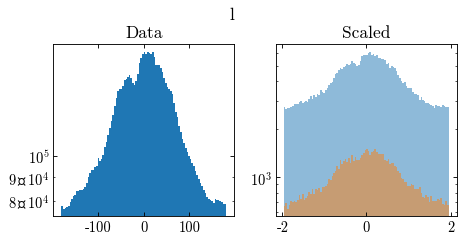

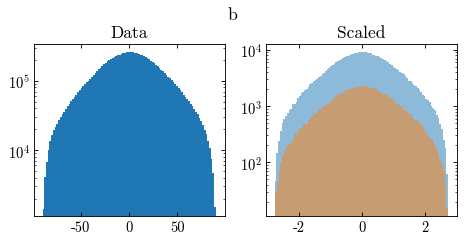

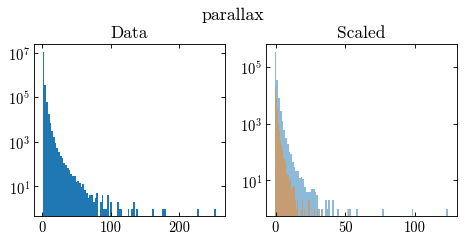

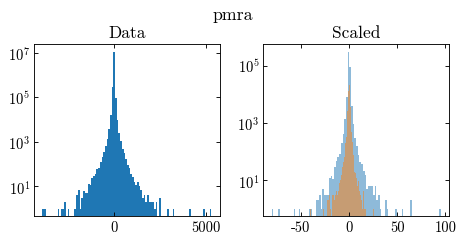

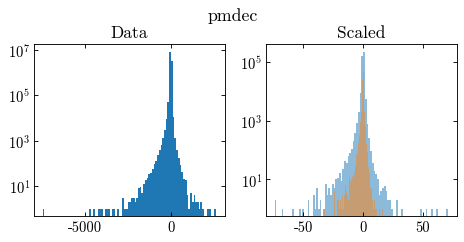

In [15]:
#visualize check data
for i, col in enumerate(use_cols):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.hist(data[col], bins=100)
    plt.yscale('log')
    plt.title('Data')
    
    plt.subplot(1,2,2)
    plt.hist(X_train[:, i], bins=100, alpha=0.5)
    plt.hist(X_test[:, i], bins=100, alpha=0.5)
    plt.yscale('log')
    plt.title('Scaled')
    
    plt.suptitle(col, y=1.01, fontsize=16)
    
    plt.tight_layout()

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [17]:
from keras import backend as K

In [18]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1])
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    
    ARG = K.square(X - LOC) / (2 * K.square(SIGMA))
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    #you get this from the conditional probability distribution
    return K.mean(ARG - PREFACT)
#returns [vr predicted, sigma]

In [19]:
def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    ARG = -K.square(X - LOC) / (2.0)
    return K.mean(-ARG)


Going to train once on Constant Likelihood first. 

In [20]:
MyModel = Sequential()
MyModel.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=2))
#using tanh activation function in the last layer
#MyModel.compile(loss='mean_squared_error',
               # optimizer='adam'
              # )
MyModel.compile(loss=ConstantLikelihoodLossFunction,
                optimizer='adam'
               )

In [21]:
MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
_________________________________________________________________


In [22]:
#training any checkpoint or early stopping? 
es = EarlyStopping(patience=2, restore_best_weights=True)

In [23]:
history = MyModel.fit(X_train,np.vstack([y_train,
                                  np.ones(y_train.shape[0])
                                  ]).T,
                      validation_split=0.2,
                      epochs=15,
                      batch_size=1000,
                      callbacks = [es],
                      sample_weight=weights
                     )
#not sure exactly how many epochs I should run this for....we'll see 
#loss is still really small numbers- because of rescaling and then re-weighting

Train on 319999 samples, validate on 80000 samples
Epoch 1/15
319999/319999 [==============================] - 2s 6us/step - loss: 0.4170 - val_loss: 0.3843
Epoch 2/15
319999/319999 [==============================] - 2s 5us/step - loss: 0.3888 - val_loss: 0.3713
Epoch 3/15
319999/319999 [==============================] - 2s 5us/step - loss: 0.3806 - val_loss: 0.3638
Epoch 4/15
319999/319999 [==============================] - 2s 5us/step - loss: 0.3730 - val_loss: 0.3587
Epoch 5/15
319999/319999 [==============================] - 2s 5us/step - loss: 0.3677 - val_loss: 0.3588
Epoch 6/15
319999/319999 [==============================] - 2s 5us/step - loss: 0.3640 - val_loss: 0.3544
Epoch 7/15
319999/319999 [==============================] - 2s 5us/step - loss: 0.3631 - val_loss: 0.3523
Epoch 8/15
319999/319999 [==============================] - 2s 5us/step - loss: 0.3599 - val_loss: 0.3511
Epoch 9/15
319999/319999 [==============================] - 2s 5us/step - loss: 0.3590 - val_loss: 0.

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

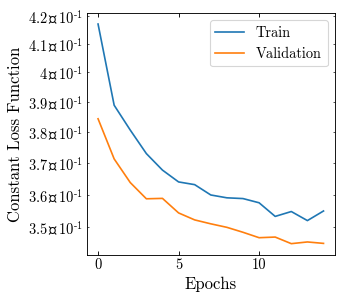

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Constant Loss Function')
plt.legend(['Train', 'Validation'])
plt.show()

Next going to train on Likelihood to get sigma 

In [25]:
MyModel.compile(loss=LikelihoodLossFunction,
                optimizer='adam'
               )

In [26]:
history = MyModel.fit(X_train,np.vstack([y_train,
                                  np.ones(y_train.shape[0])
                                  ]).T,
                      validation_split=0.2,
                      epochs=300,
                      batch_size=1000,
                      callbacks = [es],
                      sample_weight=weights
                     )

Train on 319999 samples, validate on 80000 samples
Epoch 1/300
319999/319999 [==============================] - 2s 6us/step - loss: 2018.1334 - val_loss: 0.0697
Epoch 2/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0669 - val_loss: 0.0696
Epoch 3/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0408 - val_loss: 0.0059
Epoch 4/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0040 - val_loss: 0.0029
Epoch 5/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0025 - val_loss: 0.0022
Epoch 6/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 7/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 8/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 9/300
319999/319999 [==============================] - 2s 5us/step - loss: 0.0014 - 

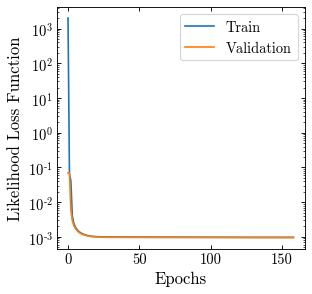

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Likelihood Loss Function')
plt.legend(['Train', 'Validation'])
plt.show()

In [28]:
# predict the scores for the test set, then histogram them based on the real labels
test_preds = MyModel.predict(X_test)

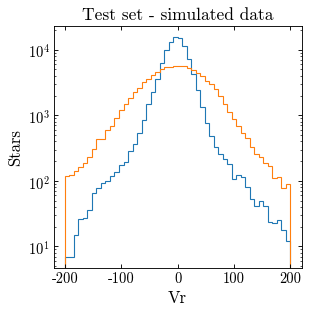

In [29]:
plt.hist(test_preds[:,0], bins=50, range=(-200,200), histtype='step')
plt.hist(y_test, bins=50, range=(-200,200), histtype='step')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.show()

[ -54.893066 -122.85788   -53.524967 ...  -69.15652   -50.176765
  -53.597622]


Text(0, 0.5, 'Error on Vr predicted')

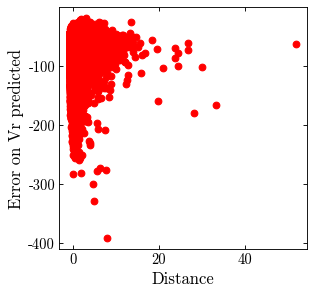

In [30]:
#test_preds[:,0] = (test_preds[:,0] - np.min(test_preds[:,0]))/(np.max(test_preds[:,0])- np.min(test_preds[:,0]))
#test_preds[:,1] = (test_preds[:,1] - np.min(test_preds[:,1]))/(np.max(test_preds[:,1])- np.min(test_preds[:,1]))
#y_test = (y_test - np.min(y_test))/(np.max(y_test)- np.min(y_test))
#manually normalizing output 
print(test_preds[:,1])
plt.scatter(X_test[:,2], test_preds[:,1], color = 'red')
#plt.errorbar(X_test[1:50,2], test_preds[1:50,0], yerr = test_preds[1:50,1], color = 'red',ls='none')
plt.xlabel('Distance')
plt.ylabel('Error on Vr predicted')

In [31]:
from scipy.interpolate import interpn
def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )
    return ax

Text(0.5, 0, 'Vr real')

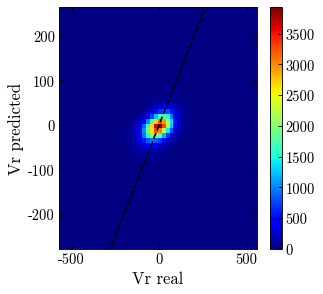

In [32]:
#plt.errorbar(y_test, test_preds[:,0], yerr = test_preds[:,1], color = 'red',ls='none')
#density_scatter(y_test, test_preds[:,0])
h = plt.hist2d(y_test, test_preds[:,0], (50, 50), cmap=plt.cm.jet)
plt.colorbar(h[3])

x = np.linspace(np.min(y_test),np.max(y_test),100)
y = x
plt.plot(x,y,'k--')
plt.ylabel('Vr predicted')
plt.xlabel('Vr real')

In [33]:
from scipy.stats import gaussian_kde
x = y_test
y = test_preds[:,0]
xy = np.vstack([y_test,test_preds[:,0]])
z = gaussian_kde(xy)(xy)



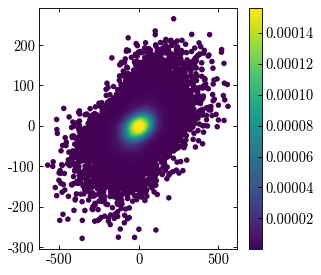

In [34]:
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x = y_test
y = test_preds[:,0]
x, y, z = x[idx], y[idx], z[idx]
fig, ax = plt.subplots()
cax = ax.scatter(x, y, c=z, s=25, edgecolor='')
fig.colorbar(cax)
#plt.errorbar(y_test, test_preds[:,0], yerr = test_preds[:,1], color = 'red',ls='none')